In [60]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

In [61]:
import sys

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
src_path = os.path.join(project_root, "src")

if src_path not in sys.path:
    sys.path.append(src_path)

In [62]:
data_dir_path = os.path.join("..", "data", "gridloss", "train.csv")
df = pd.read_csv(data_dir_path, index_col=0)
df.index = pd.to_datetime(df.index)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17520 entries, 2017-12-01 00:00:00 to 2019-11-30 23:00:00
Data columns (total 38 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   demand                     17518 non-null  float64
 1   grid1-load                 17520 non-null  float64
 2   grid1-loss                 17519 non-null  float64
 3   grid1-loss-prophet-daily   16775 non-null  float64
 4   grid1-loss-prophet-pred    16775 non-null  float64
 5   grid1-loss-prophet-trend   16775 non-null  float64
 6   grid1-loss-prophet-weekly  16775 non-null  float64
 7   grid1-loss-prophet-yearly  16775 non-null  float64
 8   grid1-temp                 17518 non-null  float64
 9   grid2-load                 17520 non-null  float64
 10  grid2-loss                 17519 non-null  float64
 11  grid2-loss-prophet-daily   16775 non-null  float64
 12  grid2-loss-prophet-pred    16775 non-null  float64
 13  grid2-loss-

In [63]:
# Backfill missing data
df = df.bfill()

# print(df.isnull().sum())

In [64]:
from utils.generate_dataset import generate_windows_dataset

grid1_columns = ["grid1-load","grid1-loss","grid1-temp"]
window_size = 168 # 1 week
step_size = 1 # 1 hour
# step_size = 24 # 1 day
# step_size = 48 # 2 day
# step_size = 168 # 1 week
num_ts = len(grid1_columns)
dataset_size = (df.shape[0] - window_size)//step_size + 1

windows_data_paths = [os.path.join("..", "data", "gridloss", "windows", f"ts{i}_w{window_size}_s{step_size}_n{dataset_size}.csv") for i in range(num_ts)]

load_windows: bool = all([os.path.exists(path) for path in windows_data_paths])
if not load_windows:
    data = generate_windows_dataset(df, window_size, step_size, grid1_columns)
else:
    data_transposed = [pd.read_csv(path).to_numpy() for path in windows_data_paths]
    data = np.asarray(data_transposed).transpose(1, 2, 0).tolist()

print(type(data), np.asarray(data).shape)

<class 'list'> (17353, 168, 3)


In [38]:
# Save windows to file
data_transposed = np.asarray(data).transpose(2,0,1)

for i in range(num_ts):
    if not os.path.exists(windows_data_paths[i]):
        pd.DataFrame(data_transposed[1]).to_csv(windows_data_paths[i], index=False)

In [ ]:
from utils.features import decomp_and_features

sp = 24 # STL parameter
# Params for loading features
load_features = True
load_run_id = 2
runs = [[168, 1, 17353],
        [168, 24, 724],
        [168, 48, 362],
        [168, 168, 104]]

ld_window_size = runs[load_run_id][0]
ld_step_size = runs[load_run_id][1]
ld_dataset_size = runs[load_run_id][2]

# NOTE: Currently not using, saving or loading decompositions
if not load_features:
    # Calculate features
    decomps, features = decomp_and_features(data, series_periodicity=sp, dataset_size=dataset_size)
    print(np.asarray(decomps).shape, features.shape)
else:
    # Load features from file
    feature_dfs = []
    for i in range(num_ts):
        features_path = os.path.join("..", "data", "gridloss", "features", f"features_ts{i}_w{ld_window_size}_s{ld_step_size}_n{ld_dataset_size}.csv")
        feature_dfs.append(pd.read_csv(features_path).to_numpy())

    features = np.asarray(feature_dfs)
    features = features.transpose(1, 0, 2)
    print(features.shape)

(362, 3, 4)


In [38]:
# Save features to file
features_paths = [os.path.join("..", "data", "gridloss", "features", f"features_ts{i}_w{window_size}_s{step_size}_n{dataset_size}.csv") for i in range(num_ts)]

for i in range(num_ts):
    if not os.path.exists(features_paths[i]):
        pd.DataFrame(features[:,i]).to_csv(features_paths[i], index=False)

In [39]:
from sklearn.decomposition import PCA
print(features.shape)
mts_features_reshape = features.reshape((features.shape[0], features.shape[1]*features.shape[2]))
print(mts_features_reshape.shape)

pca_2d = PCA(n_components=2)
mts_pca_2d = pca_2d.fit_transform(mts_features_reshape)

(362, 3, 4)
(362, 12)


In [40]:
mts_pca_df = pd.DataFrame(data=mts_pca_2d, columns=["pca1", "pca2"])
mts_pca_df['index'] = mts_pca_df.index

In [47]:
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [42]:
fig = px.scatter(mts_pca_df, x='pca1', y='pca2', hover_data=['index'])
fig.show()

In [49]:
mts_index = 166

fig = make_subplots(rows=3, cols=1)

fig.add_trace(go.Line(x=data[mts_index].index, y=data[mts_index]["grid1-load"], name="grid1-load"), row=1, col=1)
fig.add_trace(go.Line(x=data[mts_index].index, y=data[mts_index]["grid1-loss"], name="grid1-loss"), row=2, col=1)
fig.add_trace(go.Line(x=data[mts_index].index, y=data[mts_index]["grid1-temp"], name="grid1-temp"), row=3, col=1)

fig.update_layout(height=600, width=800, title_text=f"MTS index {mts_index}")

fig.show()


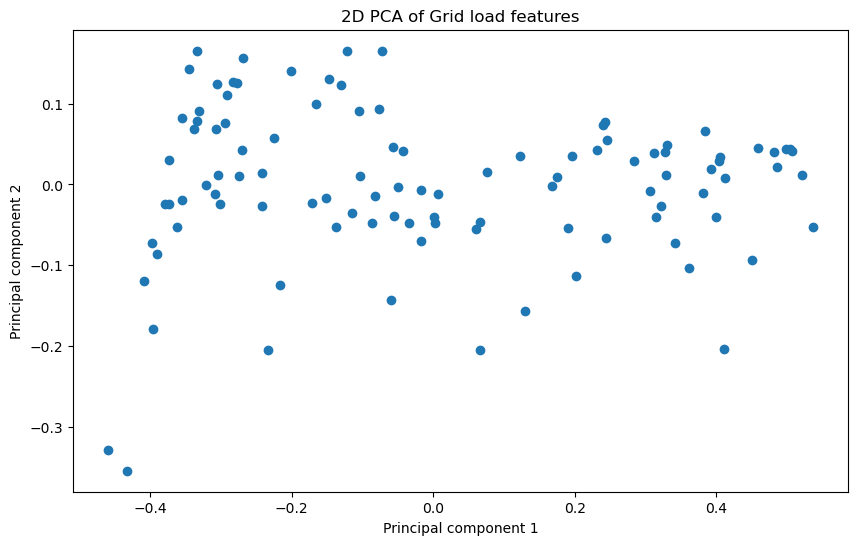

In [37]:
ts1_features_reshape = mts_features_reshape[:,0:4]

pca_2d = PCA(n_components=2)
ts1_pca_2d = pca_2d.fit_transform(ts1_features_reshape)

plt.figure(figsize=(10, 6))
plt.scatter(ts1_pca_2d[:, 0], ts1_pca_2d[:, 1])
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')
plt.title('2D PCA of Grid load features')
plt.show()

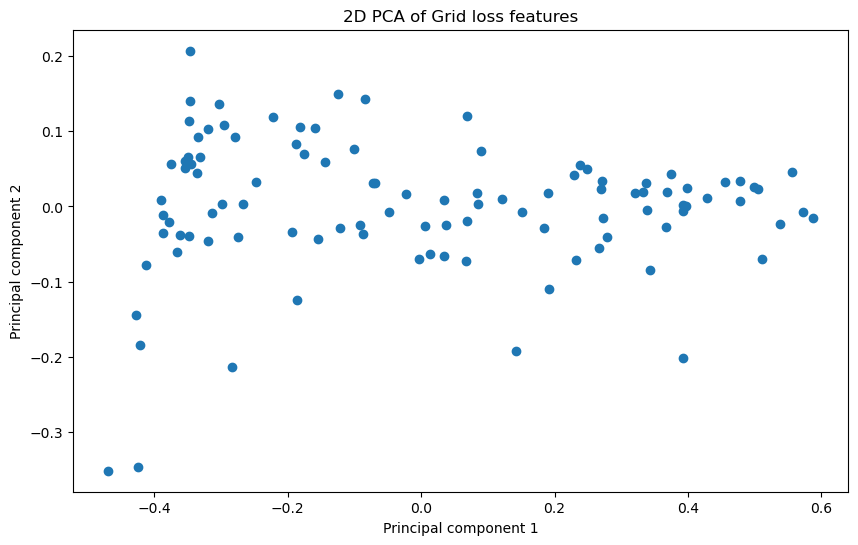

In [38]:
ts2_features_reshape = mts_features_reshape[:,4:8]

pca_2d = PCA(n_components=2)
ts2_pca_2d = pca_2d.fit_transform(ts2_features_reshape)

plt.figure(figsize=(10, 6))
plt.scatter(ts2_pca_2d[:, 0], ts2_pca_2d[:, 1])
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')
plt.title('2D PCA of Grid loss features')
plt.show()

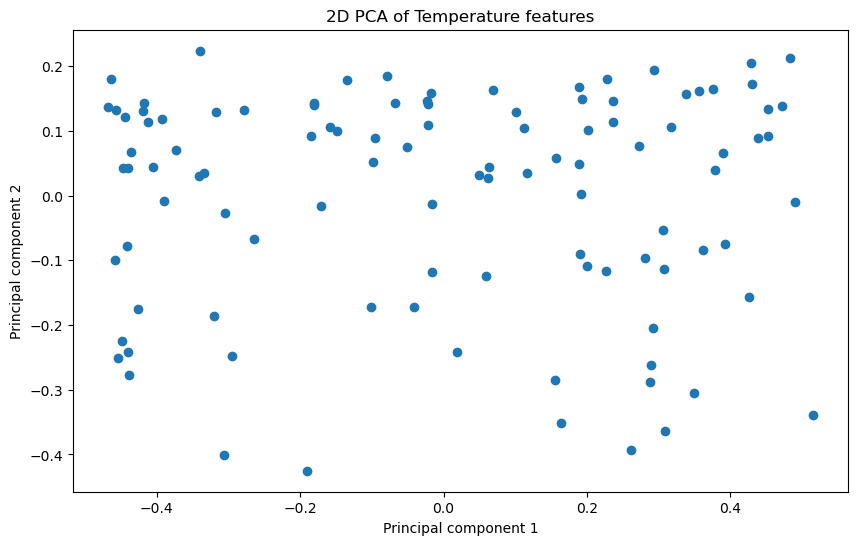

In [39]:
ts3_features_reshape = mts_features_reshape[:,8:12]

pca_2d = PCA(n_components=2)
ts3_pca_2d = pca_2d.fit_transform(ts3_features_reshape)

plt.figure(figsize=(10, 6))
plt.scatter(ts3_pca_2d[:, 0], ts3_pca_2d[:, 1])
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')
plt.title('2D PCA of Temperature features')
plt.show()